In [ ]:
import pandas as pd
import os
from google.colab import files
import seaborn as sns
import matplotlib.pyplot as plt
import io
import numpy as np
uploaded = files.upload()

Saving student-mat.csv to student-mat.csv


In [ ]:
# Imports and checks for nulls
df = pd.read_csv(io.BytesIO(uploaded['student_performance.csv']))
df.isnull().sum()


NameError: ignored

In [ ]:
# text categories to ints

df = df.replace({'gender':{'female':1, 'male':0}})
df = df.replace({'race/ethnicity':{'group A':0, 'group B':1, 'group C':2, 'group D': 3, 'group E':4}})
df = df.replace({'parental level of education':{"master's degree":0, "bachelor's degree":1, 'some college':2, "associate's degree": 3, 'high school':4, 'some high school':5}})
df = df.replace({'lunch':{'free/reduced':1, 'standard':0}})
df = df.replace({'test preparation course':{'completed':1, 'none':0}})
df['total'] = df['math score'] + df['reading score'] + df['writing score']

# renames columns for simplicity
df.columns = ['gender', 'race','p_ed', 'lunch','prep','math','reading','writing','total']

# creates new columns for the grouped target variable
# with limited features the model had 0 AUC when trying to predict the EXACT score
# I grouped scores later into a range (0-10, 11-20 etc) for the target val
df['math_cat'] = df['math']
df['reading_cat'] = df['reading']
df['writing_cat'] = df['writing']
df['total_cat'] = df['total']

In [ ]:
#copy for when we relable the target categories 
df_wcat = df.copy()
df_wcat

,gender,race,p_ed,lunch,prep,math,reading,writing,total,math_cat,reading_cat,writing_cat,total_cat
0,1,1,1,0,0,72,72,74,218,72,72,74,218
1,1,2,2,0,1,69,90,88,247,69,90,88,247
2,1,1,0,0,0,90,95,93,278,90,95,93,278
3,0,0,3,1,0,47,57,44,148,47,57,44,148
4,0,2,2,0,0,76,78,75,229,76,78,75,229
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,4,0,0,1,88,99,95,282,88,99,95,282
996,0,2,4,1,0,62,55,55,172,62,55,55,172
997,1,2,4,1,1,59,71,65,195,59,71,65,195
998,1,3,2,0,1,68,78,77,223,68,78,77,223


In [ ]:
#Creates lists for bin ranges and bin labels
bins_list = list(range(0,301,10))
bin_labels = list(range(0,299,10))

#assigns labels based on range
#since the target has to be numerical vals are rounded down to the nearest 10
# ex/ 83 is rounded down to 80
df_wcat['math_cat'] = pd.cut(x=df_wcat['math_cat'], bins=bins_list, labels=bin_labels)
df_wcat['reading_cat'] = pd.cut(x=df_wcat['reading_cat'], bins=bins_list,labels=bin_labels)
df_wcat['writing_cat'] = pd.cut(x=df_wcat['writing_cat'], bins=bins_list,labels=bin_labels)
df_wcat['total_cat'] = pd.cut(x=df_wcat['total_cat'], bins=bins_list,labels=bin_labels)

#Because of how the ranges work I was getting nan when the original score was 0 
#Corrects that 
df_wcat = df_wcat.fillna(0)
df_wcat

,gender,race,p_ed,lunch,prep,math,reading,writing,total,math_cat,reading_cat,writing_cat,total_cat
0,1,1,1,0,0,72,72,74,218,70,70,70,210
1,1,2,2,0,1,69,90,88,247,60,80,80,240
2,1,1,0,0,0,90,95,93,278,80,90,90,270
3,0,0,3,1,0,47,57,44,148,40,50,40,140
4,0,2,2,0,0,76,78,75,229,70,70,70,220
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,4,0,0,1,88,99,95,282,80,90,90,280
996,0,2,4,1,0,62,55,55,172,60,50,50,170
997,1,2,4,1,1,59,71,65,195,50,70,60,190
998,1,3,2,0,1,68,78,77,223,60,70,70,220


In [ ]:

#Checking to make sure the math_cat 0 score is no longer nan (can remove later)
bool_null = pd.isnull(df_wcat["math_cat"])    
df_wcat[bool_null]  


,gender,race,p_ed,lunch,prep,math,reading,writing,total,math_cat,reading_cat,writing_cat,total_cat


In [ ]:
from sklearn.model_selection import train_test_split
#Breaks test/train for total score prediction
feature_cols = ['gender', 'race', 'p_ed', 'lunch', 'prep']
X = df_wcat[feature_cols]
y = df_wcat['total_cat']

X_train, X_test, Y_train, Y_test = train_test_split(X,y,random_state=42)


In [ ]:
#Fits for total score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus
from sklearn.metrics import accuracy_score

clf = DecisionTreeClassifier()
clf.fit(X_train, Y_train)

NameError: ignored

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

#Feature importance for total score prediction

hist_df = pd.DataFrame({'feature importance': clf.feature_importances_}, index=X.columns).sort_values(by='feature importance', ascending=True)

hist_df.plot(kind='bar',y='feature importance', color='blue')


NameError: ignored

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn import metrics

# AUC for total score prediction

Y_predict = clf.predict(X_test)

total_acc_score = accuracy_score(Y_test, Y_predict)
total_acc_score


0.044

In [ ]:
# math score predict

y_math = df_wcat['math_cat']

mathX_train, mathX_test, mathY_train, mathY_test = train_test_split(X,y_math, random_state=42)

math_clf = DecisionTreeClassifier()
math_clf.fit(mathX_train, mathY_train)

mathY_predict = math_clf.predict(mathX_test)


math_acc = accuracy_score(mathY_test, mathY_predict)
math_acc

0.232

In [ ]:
#reading score prediction

y_read = df_wcat['reading_cat']

readX_train, readX_test, readY_train, readY_test = train_test_split(X,y_read, random_state=42)

read_clf = DecisionTreeClassifier()
read_clf.fit(readX_train, readY_train)

readY_predict = read_clf.predict(readX_test)

read_score = accuracy_score(readY_test, readY_predict)
read_score

0.208

In [ ]:
#writing score prediction

y_write = df_wcat['writing_cat']


writeX_train, writeX_test, writeY_train, writeY_test = train_test_split(X,y_write, random_state=42)

write_clf = DecisionTreeClassifier()
write_clf.fit(writeX_train, writeY_train)

writeY_predict = write_clf.predict(writeX_test)

write_score = accuracy_score(writeY_test, writeY_predict)
write_score

0.212

In [ ]:
### predict the writing score using reading score

feature_cols2 = ['gender', 'race', 'p_ed', 'lunch', 'prep', 'reading']
X2 = df[feature_cols2]

y_write2 = df_wcat['writing_cat']

writeX_train2, writeX_test2, writeY_train2, writeY_test2 = train_test_split(X2,y_write2, random_state=42)

write_clf2 = DecisionTreeClassifier()
write_clf2.fit(writeX_train2, writeY_train2)

writeY_predict2 = write_clf2.predict(writeX_test2)

write_score2 = accuracy_score(writeY_test2, writeY_predict2)
write_score2

0.516

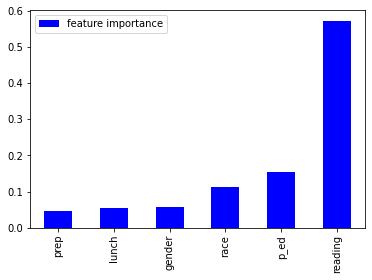

In [ ]:
# Feature importance when including the reading score to predict writing score

hist_df = pd.DataFrame({'feature importance': write_clf2.feature_importances_}, index=X2.columns).sort_values(by='feature importance', ascending=True)

hist_df.plot(kind='bar',y='feature importance', color='blue')

## Losgistic Regression and KNN

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import seaborn as sns

In [ ]:

# logistic regression to predict total score
lr = LogisticRegression()
lr.fit(X_train, Y_train)

lr_pred = lr.predict(X_test)    #logistic regression's prediction
lr_total_acc_score = accuracy_score(Y_test, lr_pred)
lr_total_acc_score

NameError: ignored

Logistic Regression only gives 9.6% accuracy on total score prediction. Both logstic regression and decision trees perform poorly. This is mainly due to the lack of independent variables. Here, we import another dataset, containing students' info and their math score.

In [ ]:
score = pd.read_csv(io.BytesIO(uploaded['student-mat.csv']))
score.head()
from sklearn.metrics import accuracy_score


1 school - student's school (binary: 'GP' - Gabriel Pereira or 'MS' - Mousinho da Silveira)  
2 sex - student's sex (binary: 'F' - female or 'M' - male)  
3 age - student's age (numeric: from 15 to 22)  
4 address - student's home address type (binary: 'U' - urban or 'R' - rural)  
5 famsize - family size (binary: 'LE3' - less or equal to 3 or 'GT3' - greater than 3)  
6 Pstatus - parent's cohabitation status (binary: 'T' - living together or 'A' - apart)  
7 Medu - mother's education (numeric: 0 - none, 1 - primary education (4th grade), 2 â€“ 5th to 9th grade, 3 â€“ secondary education or 4 â€“ higher education)  
8 Fedu - father's education (numeric: 0 - none, 1 - primary education (4th grade), 2 â€“ 5th to 9th grade, 3 â€“ secondary education or 4 â€“ higher education)  
9 Mjob - mother's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')  
10 Fjob - father's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')  
11 reason - reason to choose this school (nominal: close to 'home', school 'reputation', 'course' preference or 'other')  
12 guardian - student's guardian (nominal: 'mother', 'father' or 'other')  
13 traveltime - home to school travel time (numeric: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour)  
14 studytime - weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)  
15 failures - number of past class failures (numeric: n if 1<=n<3, else 4)  
16 schoolsup - extra educational support (binary: yes or no)  
17 famsup - family educational support (binary: yes or no)  
18 paid - extra paid classes within the course subject (Math or Portuguese)(binary: yes or no)  
19 activities - extra-curricular activities (binary: yes or no)  
20 nursery - attended nursery school (binary: yes or no)  
21 higher - wants to take higher education (binary: yes or no)  
22 internet - Internet access at home (binary: yes or no)  
23 romantic - with a romantic relationship (binary: yes or no)  
24 famrel - quality of family relationships (numeric: from 1 - very bad to 5 - excellent)  
25 freetime - free time after school (numeric: from 1 - very low to 5 - very high)  
26 goout - going out with friends (numeric: from 1 - very low to 5 - very high)  
27 Dalc - workday alcohol consumption (numeric: from 1 - very low to 5 - very high)  
28 Walc - weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)  
29 health - current health status (numeric: from 1 - very bad to 5 - very good)  
30 absences - number of school absences (numeric: from 0 to 93)  
31 G1 - first period grade (numeric: from 0 to 20)  
31 G2 - second period grade (numeric: from 0 to 20)  
32 G3 - final grade (numeric: from 0 to 20, output target)  

In [ ]:
score.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,16.696203,2.749367,2.521519,1.448101,2.035443,0.334177,3.944304,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861,10.908861,10.713924,10.415190
std,1.276043,1.094735,1.088201,0.697505,0.839240,0.743651,0.896659,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096,3.319195,3.761505,4.581443
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000,9.000000,8.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


Drop G1 and G2 columns since they are highly indictive to G3 and will cause data leakage. we only predict final grade, i.e. G3.

In [ ]:
score = score.drop(['G1', 'G2'], axis=1)
score.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,10
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,10


We convert all binary variables to intergers:

In [ ]:
score['address'] = score['address'].apply(lambda x: 0 if x == 'U' else 1) # 0 for urban 1 for rural
score['famsize'] = score['famsize'].apply(lambda x: 0 if x == 'LE3' else 1) # 0 for family size < 3 and 1 otherwise
score['Pstatus'] = score['Pstatus'].apply(lambda x: 0 if x == 'T' else 1) # 0 if parents live together and 1 otherwise
score['famsup'] = score['famsup'].apply(lambda x: 0 if x == 'no' else 1) # 0 = no and 1 = yes
score['paid'] = score['paid'].apply(lambda x: 0 if x == 'no' else 1) # 0 = no and 1 = yes
score['activities'] = score['activities'].apply(lambda x: 0 if x == 'no' else 1) # 0 = no and 1 = yes
score['higher'] = score['higher'].apply(lambda x: 0 if x == 'no' else 1)
score['internet'] = score['internet'].apply(lambda x: 0 if x == 'no' else 1)
score['romantic'] = score['romantic'].apply(lambda x: 0 if x == 'no' else 1)
score['nursery'] = score['nursery'].apply(lambda x: 0 if x == 'no' else 1)
score['guardian'] = score['guardian'].apply(lambda x: 0 if x == 'mother' else (1 if x=='father' else 2))
score['reason'] = score['reason'].apply(lambda x: 0 if x == 'home' else (1 if x=='reputation' else (3 if x=='course' else 4)))
score['school'] = score['school'].apply(lambda x: 0 if x == 'GP' else 1)
score['schoolsup'] = score['schoolsup'].apply(lambda x: 0 if x == 'no' else 1)
score['sex'] = score['sex'].apply(lambda x: 0 if x == 'F' else 1) # feamle 0 male 1

In [ ]:
score.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G3
0,0,0,18,0,1,1,4,4,at_home,teacher,3,0,2,2,0,1,0,0,0,1,1,0,0,4,3,4,1,1,3,6,6
1,0,0,17,0,1,0,1,1,at_home,other,3,1,1,2,0,0,1,0,0,0,1,1,0,5,3,3,1,1,3,4,6
2,0,0,15,0,0,0,1,1,at_home,other,4,0,1,2,3,1,0,1,0,1,1,1,0,4,3,2,2,3,3,10,10
3,0,0,15,0,1,0,4,2,health,services,0,0,1,3,0,0,1,1,1,1,1,1,1,3,2,2,1,1,5,2,15
4,0,0,16,0,1,0,3,3,other,other,0,1,1,2,0,0,1,1,0,1,1,0,0,4,3,2,1,2,5,4,10


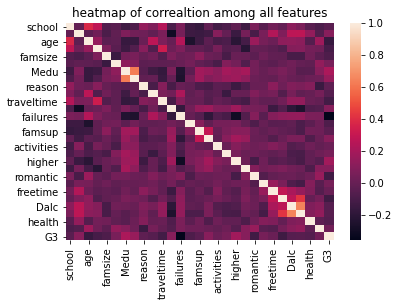

In [ ]:
score.corr()
sns.heatmap(score.corr())
plt.title('heatmap of correaltion among all features')
plt.show()

Use PCA to extract most important features and compress dimensions:

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
dropped = score.drop(['G3','Mjob','Fjob'], axis=1) # drop target variables and other features that won'e be in the model
dropped.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
0,0,0,18,0,1,1,4,4,3,0,2,2,0,1,0,0,0,1,1,0,0,4,3,4,1,1,3,6
1,0,0,17,0,1,0,1,1,3,1,1,2,0,0,1,0,0,0,1,1,0,5,3,3,1,1,3,4
2,0,0,15,0,0,0,1,1,4,0,1,2,3,1,0,1,0,1,1,1,0,4,3,2,2,3,3,10
3,0,0,15,0,1,0,4,2,0,0,1,3,0,0,1,1,1,1,1,1,1,3,2,2,1,1,5,2
4,0,0,16,0,1,0,3,3,0,1,1,2,0,0,1,1,0,1,1,0,0,4,3,2,1,2,5,4


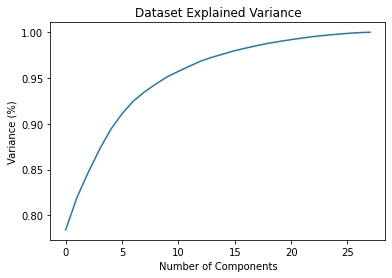

In [ ]:
pca = PCA().fit(dropped)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Dataset Explained Variance')
plt.show()

We will use first 10 principal components becasue they expalin more than 95% variance. We successfully compress original 28 columns to just 10.

In [ ]:
pca = PCA(n_components=10)
pca_score = pca.fit_transform(dropped)
pcadf = pd.DataFrame(data=pca_score,
                     columns=['principal component 1', 'principal component 2','principal component 3','principal component 4','principal component 5','principal component 6','principal component 7','principal component 8','principal component 9','principal component 10'])
pcadf.shape

(395, 10)

In [ ]:
Y = score['G3'].apply(lambda x: 1 if x > 12 else 0) # > 12 then pass, 1 else fail, 0
print(Y.shape)
print(dropped.shape)

(395,)
(395, 28)


## Logistic Regression:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(pcadf, Y, test_size=0.33, random_state=42)

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_acc_score = accuracy_score(y_test, lr_pred)
lr_acc_score

0.6870229007633588

In [ ]:
lr_prob = lr.predict_proba(X_test)[:,1]
lr_auc = roc_auc_score(y_test, lr_prob)
print('AUC for logistic regression: %.2f' % lr_auc)

AUC for logistic regression: 0.71


Parameters tuning:

In [ ]:
C_param_range = [0.001,0.01,0.1,1,10,100]

for c in C_param_range:
  lr = LogisticRegression(C=c)
  lr.fit(X_train, y_train)
  lr_pred = lr.predict(X_test)
  lr_acc_score = accuracy_score(y_test, lr_pred)
  print('accuracy for c=',c,'is',lr_acc_score)
  lr_prob = lr.predict_proba(X_test)[:,1]
  lr_auc = roc_auc_score(y_test, lr_prob)
  print('AUC for c=',c,'is',lr_auc)
  print('\n')

accuracy for c= 0.001 is 0.6717557251908397
AUC for c= 0.001 is 0.6083509513742071


accuracy for c= 0.01 is 0.6641221374045801
AUC for c= 0.01 is 0.6918604651162791


accuracy for c= 0.1 is 0.7022900763358778
AUC for c= 0.1 is 0.7079809725158562


accuracy for c= 1 is 0.6870229007633588
AUC for c= 1 is 0.708245243128964


accuracy for c= 10 is 0.6870229007633588
AUC for c= 10 is 0.7077167019027484


accuracy for c= 100 is 0.6870229007633588
AUC for c= 100 is 0.7077167019027484




C = 0.1 is the best performing parameter

### KNN

In [ ]:
klist = [2,3,4,5,6]

for k in klist:
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, y_train)
  knn_pred = knn.predict(X_test)
  knn_acc_score = accuracy_score(y_test, knn_pred)
  print('accuracy for k=',k,'is',knn_acc_score)
  knn_auc = roc_auc_score(y_test, knn_pred)
  print('AUC for k=',k,'is',knn_auc)
  print('\n')

accuracy for k= 2 is 0.6717557251908397
AUC for k= 2 is 0.541622621564482


accuracy for k= 3 is 0.7022900763358778
AUC for k= 3 is 0.6357029598308668


accuracy for k= 4 is 0.6641221374045801
AUC for k= 4 is 0.5359408033826638


accuracy for k= 5 is 0.6412213740458015
AUC for k= 5 is 0.5367336152219874


accuracy for k= 6 is 0.6641221374045801
AUC for k= 6 is 0.5181025369978858




Best performing k is k=3 which gives 70% accuracy and 0.6357 accuracy score. Logistic Regression outperforms KNN.

Will bootstrap increase the performance of logistic regression model?

In [ ]:
train = X_train
train['Y'] = y_train
test = X_test
test['Y'] = y_test

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
def Bootstrapper(train, test, nruns, sampsize):
    aucs = []
    
    for i in range(nruns):
        train_samp = train.iloc[np.random.randint(0, len(train), size=sampsize)] #return samplesize random int
        train_samp_x = train_samp.drop('Y',axis=1)
        train_samp_y = train_samp['Y']
        test_x = test.drop('Y',axis=1)
        test_y = test['Y']
        
        lr = LogisticRegression(C=0.1)
        lr.fit(train_samp_x, train_samp_y)
        lr_pred = lr.predict(test_x)
        lr_prob = lr.predict_proba(test_x)[:,1]
        lr_auc = roc_auc_score(test_y, lr_prob)
        aucs.append(lr_auc)
    
    meanauc = np.mean(aucs)
    std = np.sqrt(np.var(aucs))
    return meanauc, std

In [ ]:
samplesizes = [50, 100, 150, 200, 250, 300, 350]

lrmean = []
lrstd = []

for i in samplesizes:
    mean, std = Bootstrapper(train, test, 100, i)
    lrmean.append(mean)
    lrstd.append(std)
    print('For samplesize',i,'mean and std are:',mean,std)

For samplesize 50 mean and std are: 0.6242864693446089 0.06731279631352691
For samplesize 100 mean and std are: 0.6492151162790698 0.05248053293862573
For samplesize 150 mean and std are: 0.657164376321353 0.0455107035304958
For samplesize 200 mean and std are: 0.6761416490486257 0.036032297111157914
For samplesize 250 mean and std are: 0.6735385835095137 0.0377375669734507
For samplesize 300 mean and std are: 0.6816569767441861 0.03413488270923884
For samplesize 350 mean and std are: 0.6839878435517971 0.02970456461146669


# Load Data and Feature Selection

In [ ]:
from google.colab import drive
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
drive.mount('/content/drive')

f_path ="/content/drive/My Drive/Master's DS/Introduction to Data Science DSGA-1001/Project/student-mat.csv"
score = pd.read_csv(f_path)


score['address'] = score['address'].apply(lambda x: 0 if x == 'U' else 1) # 0 for urban 1 for rural
score['famsize'] = score['famsize'].apply(lambda x: 0 if x == 'LE3' else 1) # 0 for family size < 3 and 1 otherwise
score['Pstatus'] = score['Pstatus'].apply(lambda x: 0 if x == 'T' else 1) # 0 if parents live together and 1 otherwise
score['famsup'] = score['famsup'].apply(lambda x: 0 if x == 'no' else 1) # 0 = no and 1 = yes
score['paid'] = score['paid'].apply(lambda x: 0 if x == 'no' else 1) # 0 = no and 1 = yes
score['activities'] = score['activities'].apply(lambda x: 0 if x == 'no' else 1) # 0 = no and 1 = yes
score['higher'] = score['higher'].apply(lambda x: 0 if x == 'no' else 1)
score['internet'] = score['internet'].apply(lambda x: 0 if x == 'no' else 1)
score['romantic'] = score['romantic'].apply(lambda x: 0 if x == 'no' else 1)
score['nursery'] = score['nursery'].apply(lambda x: 0 if x == 'no' else 1)
score['guardian'] = score['guardian'].apply(lambda x: 0 if x == 'mother' else (1 if x=='father' else 2))
score['reason'] = score['reason'].apply(lambda x: 0 if x == 'home' else (1 if x=='reputation' else (3 if x=='course' else 4)))
score['school'] = score['school'].apply(lambda x: 0 if x == 'GP' else 1)
score['schoolsup'] = score['schoolsup'].apply(lambda x: 0 if x == 'no' else 1)
score['sex'] = score['sex'].apply(lambda x: 0 if x == 'F' else 1) # feamle 0 male 1
score = score.drop(['G1', 'G2'], axis=1)
dropped = score.drop(['G3','Mjob','Fjob'], axis=1) # drop target variables and other features that won'e be in the model

Y = score['G3'].apply(lambda x: 1 if x > 12 else 0) # > 12 then pass, 1 else fail, 0
X_train, X_test, y_train, y_test = train_test_split(dropped, Y, test_size=0.33, random_state=42)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
keeps = []
scores = {}
while (len(keeps) < len(dropped.columns)):
    best_column = ""
    best_acc = 0
    for column in dropped.columns:
        if column in keeps:
            continue
        temp_keeps = keeps + [column]
        temp_df = dropped.drop(dropped.columns.difference(temp_keeps), 1, inplace=False)
        X_train, X_test, y_train, y_test = train_test_split(temp_df, Y, test_size=0.33, random_state=42)
        clf = RandomForestClassifier()
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)
        score = accuracy_score(y_test, pred)
        if score > best_acc:
            best_acc = score
            best_column = column
    keeps.append(best_column)
    scores[len(temp_keeps)] = best_acc
    print(best_column, best_acc)

school 0.6717557251908397
absences 0.6793893129770993
famsize 0.6717557251908397
failures 0.6717557251908397
guardian 0.7022900763358778
studytime 0.7022900763358778
address 0.7022900763358778
sex 0.7175572519083969
Dalc 0.7404580152671756
famsup 0.7022900763358778
Medu 0.7251908396946565
schoolsup 0.7557251908396947
Walc 0.7862595419847328
Pstatus 0.7709923664122137
internet 0.7633587786259542
age 0.7557251908396947
reason 0.7709923664122137
traveltime 0.7709923664122137
romantic 0.7786259541984732
famrel 0.7786259541984732
activities 0.7557251908396947
nursery 0.7480916030534351
higher 0.7786259541984732
Fedu 0.7633587786259542
health 0.7938931297709924
paid 0.7480916030534351
freetime 0.7251908396946565
goout 0.7404580152671756


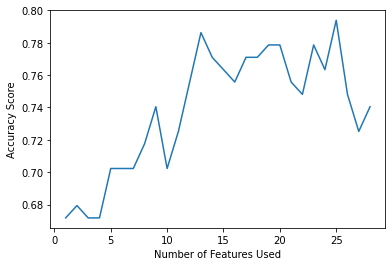

In [ ]:
plt.plot(list(scores.keys()), [scores[x] for x in scores.keys()])
plt.xlabel('Number of Features Used')
plt.ylabel('Accuracy Score') #for each component
plt.title('')
plt.show()

To conclude, our inital model with logistic regression and C=0.1 has the best performance. We will continue with that model.

# Other ML Models



In [ ]:
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(pcadf, Y, test_size=0.33, random_state=42)


names = ["Logistic Regression", "Nearest Neighbors", "SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA", "Gradient Boosting Classifier"]

default_classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(3),
    SVC(),
    GaussianProcessClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    MLPClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    GradientBoostingClassifier()]





print('X_train', len(X_train), 'y_train', len(y_train))
print('X_test', len(X_test), 'y_test', len(y_test))
for name, clf in zip(names, default_classifiers):
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    # score = clf.score(X_test, y_test)
    score = accuracy_score(y_test, pred)
    print(name, score)
    print()

X_train 264 y_train 264
X_test 131 y_test 131
Logistic Regression 0.6870229007633588

Nearest Neighbors 0.7022900763358778

SVM 0.6717557251908397

Gaussian Process 0.6564885496183206

Decision Tree 0.648854961832061

Random Forest 0.6793893129770993



/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Neural Net 0.6717557251908397

AdaBoost 0.6259541984732825

Naive Bayes 0.6564885496183206

QDA 0.6412213740458015

Gradient Boosting Classifier 0.6641221374045801



# Massive Hyperparameter/Model Grid Search

In [ ]:
params = {'Logistic Regression': {'C':[.01, .1, .5, 1]},
    'Nearest Neighbors': {'n_neighbors':[3, 5, 25, 15, 2], 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']},
    "SVM": {'C':[.01, .1, .5, 1], 'kernel': ['linear', 'poly', 'rbf']},
    "Gaussian Process":{},
    "Decision Tree":{'criterion': ['gini', 'entropy'], 'splitter':['best', 'random'], 'min_samples_leaf': [x for x in range(1, 90, 9)], 'min_samples_split': [x for x in range(2, 1002, 100)]},
    "Random Forest":{'n_estimators': [10, 50, 100, 150, 300, 425, 500, 750]},
    "Neural Net":{},
    "AdaBoost":{'n_estimators': [10, 50, 100, 150, 300, 425, 500, 750], 'learning_rate': [.1, .25, .5, 1, 1.25, 1.5, 2]},
    "Naive Bayes":{},
    "QDA":{},
    "Gradient Boosting Classifier":{},
}

results = {}
for name, clf in zip(names, default_classifiers):
    print('testing', name)
    grid = GridSearchCV(estimator = clf,
                            param_grid = params[name],
                            scoring = 'accuracy', 
                            cv = 5, 
                            verbose = 0,
                            n_jobs = -1)
    grid.fit(X_train, y_train)
    results[name] = (grid.best_estimator_, grid.best_score_, grid.score(X_test, y_test))

testing Logistic Regression
testing Nearest Neighbors
testing SVM
testing Gaussian Process
testing Decision Tree
testing Random Forest
testing Neural Net


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


testing AdaBoost
testing Naive Bayes
testing QDA
testing Gradient Boosting Classifier


In [ ]:
(x, y) = ([], [])
for model, tup in results.items():
    x.append(model)
    y.append(tup[2])
    print(model)
    print('Cross validation score', tup[1])
    print('Holdout set score', tup[2])
    print()

Logistic Regression
Cross validation score 0.6667634252539912
Holdout set score 0.6641221374045801

Nearest Neighbors
Cross validation score 0.6817126269956458
Holdout set score 0.6793893129770993

SVM
Cross validation score 0.6666908563134978
Holdout set score 0.6717557251908397

Gaussian Process
Cross validation score 0.5984760522496372
Holdout set score 0.6564885496183206

Decision Tree
Cross validation score 0.6818577648766327
Holdout set score 0.6564885496183206

Random Forest
Cross validation score 0.6894775036284471
Holdout set score 0.6717557251908397

Neural Net
Cross validation score 0.6404208998548622
Holdout set score 0.6946564885496184

AdaBoost
Cross validation score 0.6934687953555877
Holdout set score 0.6259541984732825

Naive Bayes
Cross validation score 0.6216255442670537
Holdout set score 0.6564885496183206

QDA
Cross validation score 0.6101596516690856
Holdout set score 0.6412213740458015

Gradient Boosting Classifier
Cross validation score 0.6515239477503628
Holdou

In [ ]:
print(y_train.unique())
print(len(y_train[y_train == 0]))
print(len(y_train[y_train == 1]))

[0 1]
176
88


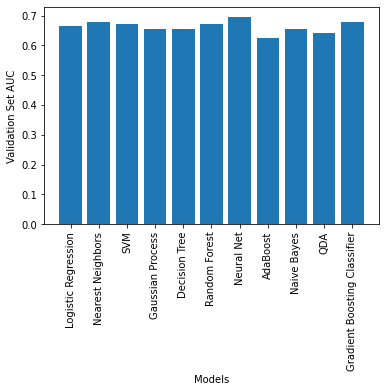

In [ ]:
plt.bar(x, y)
plt.xticks(rotation=90)
plt.xlabel('Models')
plt.ylabel('Validation Set AUC') #for each component
plt.title('')
plt.show()